# Trial for own CNN w/ pixel-targeting


In [4]:
import random
import numpy as np
import pandas as pd

import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import time

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array

-------------------------
## Import data


Loading the Image

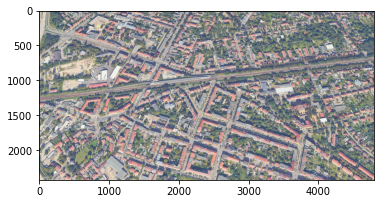

In [32]:
# load the image to get its shape
path_raw_data = 'Potsdam_sample/'
name_raw_data = 'Potsdam02s'
orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

plt.imshow(orig_image)

Loading the label-points for the picture from label studio

In [133]:
# load json
with open(f'{path_raw_data}{name_raw_data}.json', 'r') as json_file:
	json_load = json.load(json_file)

# select data
json_load = json_load[0]["annotations"][0]["result"]



labels_x = ([])
print(labels_x)
labels_y = np.array([])
counter = 0
for datapoint in json_load:
    print(datapoint["value"]["x"])
    label_x = datapoint["value"]["x"]
    print(label_x.real)
    np.append(labels_x, label_x, axis=0)
    counter +=1
#    labels_y = np.append(datapoint["y"])


([], [])
13.981023268942872
13.981023268942872


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

In [47]:

#$[0].annotations[0].result[0].value.x
orig_labels = pd.read_json(f'{path_raw_data}{name_raw_data}.json')
orig_labels = orig_labels[/0/annotations/0/result/0/value]
print("The following label-sets were uploaded:")
print(orig_labels)

# retrieve coordinates of labels
labels_x = np.array([])
labels_y = np.array([])
for part in orig_labels:
    for line in part:
        labels_x = np.append(labels_x, line["x"])
        labels_y = np.append(labels_y, line["y"])
        #labels_y.append(line["y"])
labels_unscaled = np.vstack((labels_x, labels_y)).transpose()
print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")
labels_unscaled.dtype

SyntaxError: invalid syntax (3133118884.py, line 4)

In [ ]:
# scale datapoints to image pixels
reshaper = [[(i_width/100), 0], [0,(i_height/100)]]
labels = np.mat(labels_unscaled) * np.mat(reshaper)
# check label positions
histogram_labels = plt.hist(labels, bins=100)

Matching Image and labels and show upload result

In [ ]:
plt.imshow(image)

# plot each labeled tree
for dot in labels:
    #print(dot[:,1])
    plt.plot(dot[:,0], dot[:,1], marker='*', color="green")
# show the plot
plt.show()

-------------------------
## Prepare tiles 
Tiles = child-pictures of image, all together represent the whole image
- split the picture into tiles

In [ ]:
# define the tile size
tile_size = 30
num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_locations = np.zeros((num_tiles, 3)) # (row, column, label_id)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting pixels in rows and columns
        v_start = i * tile_size
        h_start = j * tile_size
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_locations[tile_num] = (i,j,0)

print(f"Tiles are created: {tiles.shape}.")

In [ ]:
# Labeling the tiles

tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
tile_count = np.zeros((num_tiles, 1)) # number of trees in each tile
label_count = 0

for label in labels:
    pos_horizontal = label[:,0] // tile_size -1
    pos_vertical = label[:,1] // tile_size -1
    tile_num = int(pos_vertical * num_horizontal_tiles + pos_horizontal)
    tile_labels[tile_num] = 1
    tile_count[tile_num] += 1
    tile_locations[tile_num][2]= label_count
    label_count += 1

print(f"Labels vector is created: {tile_labels.shape}.")
print(f"Tiles labeled as with tree: {tile_labels.sum()}")
print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
print(f"Total trees assigned: {tile_count.sum()}.")

In [ ]:
# show labeled tiles
tiles_show = tile_locations[:,2].reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

In [ ]:
# max count tile show
print(tile_count.max())
plt.hist(tile_count)

In [ ]:
example = random.randint(0, num_tiles-1)
print(f"tile_num is: {example}")
print(f"column: {example % num_horizontal_tiles} of {num_horizontal_tiles}, row: {example // num_horizontal_tiles} of {num_vertical_tiles}")
print(f"Tile label: {tile_labels[example]}")
print(f"Tile tree count: {tile_count[example]}")
plt.imshow(tiles[example])
plt.show()

## Prepare training and validation set

In [ ]:
# split the tiles into training and validation set
train_split = 0.8

train_tiles = tiles[:int(num_tiles*train_split)]
train_labels = tile_labels[:int(num_tiles*train_split)]
val_tiles = tiles[int(num_tiles*train_split):]
val_labels = tile_labels[int(num_tiles*train_split):]
print(f"Training set: {train_tiles.shape} - ({train_split} share of all tiles)")
print(f"Validation set: {val_tiles.shape}")

In [ ]:
# build tensorflow dataset
dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

In [ ]:
def encode(tile, label):
    image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
    image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
    return image_encoded, label

batch_size = 32
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(25).batch(batch_size)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

-------
# Training
----



## model


In [ ]:
model = models.Sequential()
initializer = tf.keras.initializers.GlorotUniform(seed=42)
model.add(layers.Input(shape=(tile_size, tile_size, 3)))

model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(2,2), data_format=None))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))

model.summary()

## Train a model

In [ ]:
model_name = "02"
epochs = 20

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate,
)

In [ ]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["binary_accuracy"], label="accuracy")
    plt.plot(history["val_binary_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

history_list = {}
history_list[model_name] = history.history
render_history(history.history)
compare_histories()
tf.keras.backend.clear_session()

-------------------------
## Predict


In [ ]:
# predict
predictions = model.predict(tiles)
predictions.shape

In [ ]:
# Results of the self-prediction:
threshold = 0.3

predictions = [1 if x > threshold else 0 for x in predictions]
#count true predictions
true_predictions = [1 if x == y else 0 for x, y in zip(predictions, tile_labels)]
true_predictions_count = sum(true_predictions)

print(f"Predictions: {true_predictions_count} out of {len(predictions)} labels are identified as trees.")
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
plt.imshow(tiles_show)

-------------------------
## Save predictions


In [ ]:
# save predictions
np.savetxt('predictions_own_cnn_pixel_targeting_25tiles.txt', predictions)